In [1]:
import time
#start_program = time.time()

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate 
from scipy import special
from scipy import interpolate
import vegas
import treecorr
#import healpy as hp
#from astropy.io import fits
#from astropy.table import Table, Column
#import random
import skinematics as skin

In [23]:
# as l=0 and l=1 (and corresponding cl values of 0) are missing due to requirement of flask, we append them
# we also take only till l=8192 (before index 8191) for flask simulation
# therefore, we finally take l values from l=0 to l=8192 (and corresponding cl)

def read_cl():
    l = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(0))
    l = np.append(np.array([0.0,1.0]), l[:8191])
    cl = np.loadtxt('../data/Cell_data-f1z1f1z1.dat', usecols=(1))
    cl = np.append(np.array([0.0,0.0]), cl[:8191])
    return l, cl

l , cl = read_cl()

In [24]:
# Theoretical angular correlation function (using formula with Legendre polynomials)
def w_theta(theta):
    x = np.cos(theta)
    coeff = (2*l+1)/(4*np.pi)*cl
    w = np.polynomial.legendre.legval(x, coeff)
    return w     

def angular_length(omega_1, omega_2):
    #return np.arccos( np.around( np.cos(omega_1[0])*np.cos(omega_2[0]) +  np.sin(omega_1[0])*np.sin(omega_2[0])*np.cos(omega_1[1]-omega_2[1]), decimals=20) )
    if (np.cos(omega_1[0])*np.cos(omega_2[0]) +  np.sin(omega_1[0])*np.sin(omega_2[0])*np.cos(omega_1[1]-omega_2[1]) > 1):
        return np.arccos(1)
    elif (np.cos(omega_1[0])*np.cos(omega_2[0]) +  np.sin(omega_1[0])*np.sin(omega_2[0])*np.cos(omega_1[1]-omega_2[1]) < -1):
        return np.arccos(-1)
    else:
        return np.arccos( np.cos(omega_1[0])*np.cos(omega_2[0]) +  np.sin(omega_1[0])*np.sin(omega_2[0])*np.cos(omega_1[1]-omega_2[1]) )

def window_circular_patch(omega, omega_patch, patch_radius):
    if (angular_length(omega, omega_patch) <= patch_radius):
        return 1
    else:
        return 0

def bin_angular_scale_interval(omega_1, omega_2, theta_scale_interval):
    # theta_scale_interval is a list containing the lower and upper values of the bin (used in TreeCorr) in regular distance space in radians
    if (angular_length(omega_1, omega_2) >= theta_scale_interval[0] and angular_length(omega_1, omega_2) < theta_scale_interval[1]):
        return 1/(theta_scale_interval[1]-theta_scale_interval[0])
    else:
        return 0

theta_arr = np.linspace(0,2*t_patch_radius+0.001,10000)
w_theta_arr = w_theta(theta_arr)

w_theta_interp = interpolate.interp1d(theta_arr, w_theta_arr)
    
def lognormal_3pt_corr(omega_1, omega_2, omega_3, log_shift):
    # angular 3pt correlartion function for a lognormal density field (according to Hilbert et al.)

    #w_12 = w_theta(angular_length(omega_1, omega_2))
    #w_13 = w_theta(angular_length(omega_1, omega_3))
    #w_23 = w_theta(angular_length(omega_2, omega_3))

    w_12 = w_theta_interp(angular_length(omega_1, omega_2))
    w_13 = w_theta_interp(angular_length(omega_1, omega_3))
    w_23 = w_theta_interp(angular_length(omega_2, omega_3))

    return (log_shift**-1)*(w_12*w_13+w_12*w_23+w_13*w_23)+(log_shift**-3)*(w_12*w_13*w_23)

def area_patch(patch_radius): 
    # patch is basically a spherical cap centered around the North Pole one a sphere of unit radius
    r = 1
    return 2*np.pi*r*r*(1-np.cos(patch_radius)) # from Wikipedia

In [ ]:
"""
#########################
### Scipy integration ###
#########################

#### DOES NOT CONVERGE ####

def area_patch_scipy(patch_radius):
    # patch is basically a spherical cap centered around the North Pole one a sphere of unit radius
    def integrand(theta, phi):
        return np.sin(theta)

    area = integrate.nquad(integrand, [[0, patch_radius], [0, 2*np.pi]])[0]

    return area

def integrated_lognormal_3pt_corr(theta_scale_interval, patch_radius, log_shift, patch_area):

    def integrand(theta_1, phi_1, theta_2, phi_2, theta_3, phi_3):
        return np.sin(theta_1)*np.sin(theta_2)*np.sin(theta_3)*lognormal_3pt_corr([theta_1, phi_1], [theta_2, phi_2], [theta_3, phi_3], log_shift)*bin_angular_scale_interval([theta_1, phi_1], [theta_3, phi_3], theta_scale_interval)

    i_Xi = integrate.nquad(integrand, [[0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi]])

    return i_Xi[0] / (patch_area**2)
"""

In [25]:
"""
#########################
### Vegas integration ###
#########################

def area_patch_vegas(patch_radius):
    # patch is basically a spherical cap centered around the North Pole one a sphere of unit radius
    def integrand(x): # x[0] stands for theta, x[1] stands for phi
        return np.sin(x[0]) 

    integ = vegas.Integrator([[0, patch_radius], [0, 2*np.pi]])
    area = integ(integrand, nitn=20, neval=5000)
    #print(result.summary())
    #print('result = %s    Q = %.2f' % (result, result.Q))
    
    return area.mean  # return the weighted mean over the total number of iterations

def integrated_lognormal_3pt_corr_vegas(theta_scale_interval, patch_radius, log_shift, patch_area):

    def integrand(x):
        theta_1 = x[0]
        phi_1 = x[1]
        theta_2 = x[2]
        phi_2 = x[3]
        theta_3 = x[4]
        phi_3 = x[5]
    
        return np.sin(theta_1)*np.sin(theta_2)*np.sin(theta_3)*lognormal_3pt_corr([theta_1, phi_1], [theta_2, phi_2], [theta_3, phi_3], log_shift)*bin_angular_scale_interval([theta_1, phi_1], [theta_3, phi_3], theta_scale_interval)

    integrator = vegas.Integrator([[0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi]])

    i_Xi = integrator(integrand, nitn=20, neval=10000)

    return i_Xi.mean / (patch_area**2) # return the weighted mean over the total number of iterations divided by the patch_area squared
"""

'\ndef integrated_lognormal_3pt_corr_vegas(theta_scale_interval, patch_radius, log_shift, patch_area):\n\n    def integrand(x):\n        theta_1 = x[0]\n        phi_1 = x[1]\n        theta_2 = x[2]\n        phi_2 = x[3]\n        theta_3 = x[4]\n        phi_3 = x[5]\n    \n        return np.sin(theta_1)*np.sin(theta_2)*np.sin(theta_3)*lognormal_3pt_corr([theta_1, phi_1], [theta_2, phi_2], [theta_3, phi_3], log_shift)*delta_angular_scale_interval([theta_1, phi_1], [theta_3, phi_3], theta_scale_interval)\n\n    integrator = vegas.Integrator([[0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi], [0, patch_radius], [0, 2*np.pi]])\n\n    i_Xi = integrator(integrand, nitn=20, neval=10000)\n\n    return i_Xi.mean / (patch_area**2) # return the weighted mean over the total number of iterations divided by the patch_area squared\n'

In [26]:
##########################
### Manual integration ###
##########################

def spherical_to_cartesian(P_sph, sph_units):
    # r , theta, phi 
    r = P_sph[0]
    theta = 0
    phi = 0
    if (sph_units == 'deg'):
        theta = np.deg2rad(P_sph[1])
        phi = np.deg2rad(P_sph[2])
    elif (sph_units == 'rad'):
        theta = P_sph[1]
        phi = P_sph[2]  
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')
   
    return np.array([r*np.sin(theta)*np.cos(phi),r*np.sin(theta)*np.sin(phi),r*np.cos(theta)])

def cartesian_to_spherical(P_cart, sph_units):
    # x, y, z ---> r, theta, phi 
    x = P_cart[0]
    y = P_cart[1]
    z = P_cart[2]
    
    r = np.sqrt(x*x+y*y+z*z)
    
    theta = np.arctan2(np.sqrt(x*x+y*y), z)
        
    phi = np.arctan2(y,x)
    if phi < 0:
        phi = 2*np.pi + phi
    
    if (sph_units == 'deg'):
        return np.array([r, theta*180/np.pi, phi*180/np.pi])
    elif (sph_units == 'rad'):
        return np.array([r, theta, phi])
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')

"""
def rotate_vector_to_NP(P_sph, P_sph_units):
    theta = 0
    phi = 0
    if (P_sph_units == 'deg'):
        theta = P_sph[1]
        phi = P_sph[2]         
    elif (P_sph_units == 'rad'):
        theta = np.rad2deg(P_sph[1])
        phi = np.rad2deg(P_sph[2])
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')
        
    P_cart = spherical_to_cartesian(P_sph, P_sph_units)

    # First rotate about z axis (counter azimuthally) so as to make the point lie in the xz plane i.e. y = 0
    Rot_z = skin.rotmat.R(axis='z', angle=-phi) # skin.rotmar.R only accepts angle in degrees!   
    P_cart_xz = np.matmul(Rot_z, P_cart)
    
    # Then rotate about y axis (counter polar-wise) to make the point lie at the NP i.e. x = 0, y = 0
    Rot_y = skin.rotmat.R(axis='y', angle=-theta) # skin.rotmar.R only accepts angle in degrees!
    P_cart_NP = np.matmul(Rot_y, P_cart_xz) 
       
    return P_cart_NP
"""

def rotate_vector_to_NP_matrices(P_sph, P_sph_units):
    theta = 0
    phi = 0
    if (P_sph_units == 'deg'):
        theta = P_sph[1]
        phi = P_sph[2]         
    elif (P_sph_units == 'rad'):
        theta = np.rad2deg(P_sph[1])
        phi = np.rad2deg(P_sph[2])
    else:
        raise Exception('units should be either \'deg\' or \'rad\'')
        
    # First rotate about z axis (counter azimuthally) so as to make the point lie in the xz plane i.e. y = 0
    Rot_z = skin.rotmat.R(axis='z', angle=-phi) # skin.rotmar.R only accepts angle in degrees!   
    
    # Then rotate about y axis (counter polar-wise) to make the point lie at the NP i.e. x = 0, y = 0
    Rot_y = skin.rotmat.R(axis='y', angle=-theta) # skin.rotmar.R only accepts angle in degrees!
       
    return np.array([Rot_z, Rot_y]) # 1st rotation matrix and then 2nd rotation matrix

def draw_pt_within_patch(patch_radius):
    theta = np.random.uniform(0, patch_radius, 1)[0]
    phi =  np.random.uniform(0, 2*np.pi, 1)[0]
    
    return [theta, phi]

def draw_pt_on_circle(omega_1, theta_scale, patch_radius):
    R_1, R_2 = rotate_vector_to_NP_matrices([1, omega_1[0], omega_1[1]], 'rad')
    
    theta_2_prime = theta_scale # polar angle in the rotated frame
    
    do_iteration = True
    
    omega_2_3d_sph = np.zeros(3)
    while(do_iteration):
        phi_2_prime = np.random.uniform(0, 2*np.pi, 1)[0]
        omega_2_prime_cart = spherical_to_cartesian([1, theta_2_prime, phi_2_prime], 'rad')
        omega_2_3d_sph = cartesian_to_spherical(np.matmul(R_1.T, np.matmul(R_2.T, omega_2_prime_cart)), 'rad')

        if (omega_2_3d_sph[1] < patch_radius):
            do_iteration = False
            
    omega_2 = [omega_2_3d_sph[1], omega_2_3d_sph[2]]
    return omega_2

def integrated_lognormal_3pt_corr_manual(theta_scale, patch_radius, log_shift, patch_area):
    N = 10000

    f = 0
    for i in range(N):
        theta_1, phi_1 = draw_pt_within_patch(patch_radius)
        theta_2, phi_2 = draw_pt_within_patch(patch_radius)
        theta_3, phi_3 = draw_pt_on_circle([theta_1, phi_1], theta_scale, patch_radius)

        f += np.sin(theta_1)*np.sin(theta_2)*np.sin(theta_3)*lognormal_3pt_corr([theta_1, phi_1], [theta_2, phi_2], [theta_3, phi_3], log_shift)

    return f / N / (patch_area**2)

In [27]:
#######################################################################################################################################
#######################################################################################################################################
# Individual function tests

#t1 = [0.031, 3.2]
t1 = [0.003, 0]
t2 = [2.1, 0.7]
t3 = [0.0155, 3.141592653589793]
t4 = [0.010936910628127367, 3.141592653589793]
t5 = [0.020063089371872633, 3.141592653589793]
t6 = [0.0155, 3.141592653589793]
t7 = [0.0312, 0.4]
t8 = [0.0309, 0.4]
tL = [0.0, 0.0] # location of patch -> at the north pole

t_scale = 0.003 # test scale we are interested (in radians)

print("Angular length between t1 and t2 (in radians) = ", angular_length(t1, t2))
print("Angular length between t1 and tL (in radians)  = ", angular_length(t1, tL))
print("Angular length between t2 and tL (in radians)  = ", angular_length(t2, tL))
print("Angular length between t3 and tL (in radians)  = ", angular_length(t3, tL))
print("Angular length between t4 and t6 (in radians)  = ", angular_length(t4, t6))
print("Angular length between t5 and t6 (in radians)  = ", angular_length(t5, t6))

print("Is t1 within the patch which is centered at tL and is of size "+str(t_patch_radius)+" radians = ", window_circular_patch(t1, tL, t_patch_radius))
print("Is t2 within the patch which is centered at tL and is of size "+str(t_patch_radius)+" radians = ", window_circular_patch(t2, tL, t_patch_radius))
print("Is t7 within the patch which is centered at tL and is of size "+str(t_patch_radius)+" radians = ", window_circular_patch(t7, tL, t_patch_radius))
print("Is t8 within the patch which is centered at tL and is of size "+str(t_patch_radius)+" radians = ", window_circular_patch(t8, tL, t_patch_radius))

print("Is t1 and tL at approximately "+str(t_scale)+" radians separation =", bin_angular_scale_interval(t1, tL, [t_scale - 0.00001, t_scale + 0.00001]))

print("Angular 2-pt correlation: w(theta between t1 and t2) = ", w_theta(angular_length(t1, t2)))
print("Angular 2-pt correlation: w(theta between t4 and t6) = ", w_theta(angular_length(t4, t6)))
print("Angular 2-pt correlation: w(theta between t5 and t6) = ", w_theta(angular_length(t5, t6)))

#print("Lognormal 3-pt correlation between t1, t2, t3 = ", lognormal_3pt_corr(t1, t2, t3, log_shift))

"""
print("\n #### Scipy integration ###")

A_L = area_patch_scipy(t_patch_radius)
print("Area of the patch = ", A_L)

print("Integrated lognormal 3-pt function at angular scale "+str(t_scale)+" radians = ", integrated_lognormal_3pt_corr([t_scale - 0.00001, t_scale + 0.00001], t_patch_radius, log_shift, A_L))
"""

"""
print("\n #### Vegas integration ###")

A_L = area_patch_vegas(t_patch_radius)
print("Area of the patch = ", A_L)

print("Integrated lognormal 3-pt function at angular scale "+str(t_scale)+" radians = ", integrated_lognormal_3pt_corr_vegas([t_scale - 0.00001, t_scale + 0.00001], t_patch_radius, log_shift, A_L))
"""

print("\n #### Manual integration ###")

A_L = area_patch(t_patch_radius)
print("Area of the patch = ", A_L)

print("Integrated lognormal 3-pt function at angular scale "+str(t_scale)+" radians = ", integrated_lognormal_3pt_corr_manual(t_scale, t_patch_radius, log_shift, A_L))

Angular length between t1 and t2 (in radians) =  2.0977043840806666
Angular length between t1 and tL (in radians)  =  0.002999999999998294
Angular length between t2 and tL (in radians)  =  2.1
Angular length between t3 and tL (in radians)  =  0.015500000000003036
Angular length between t4 and t6 (in radians)  =  0.0045630893718851375
Angular length between t5 and t6 (in radians)  =  0.0045630893718851375
Is t1 within the patch which is centered at tL and is of size 0.031 radians =  1
Is t2 within the patch which is centered at tL and is of size 0.031 radians =  0
Is t7 within the patch which is centered at tL and is of size 0.031 radians =  0
Is t8 within the patch which is centered at tL and is of size 0.031 radians =  1
Is t1 and tL at approximately 0.003 radians separation = 49999.99999999987
Angular 2-pt correlation: w(theta between t1 and t2) =  1.1625634668957718e-06
Angular 2-pt correlation: w(theta between t4 and t6) =  0.046451045632497634
Angular 2-pt correlation: w(theta bet

In [ ]:
#######################################################################################################################################
#######################################################################################################################################
# Evaluate the integrated bispectrum (for lognormal density field) for given scale angles (with same bin intervals as used by treecorr for doing the numerical work with the patches)

kk = treecorr.KKCorrelation(min_sep=1, max_sep=400, nbins=30, sep_units='arcmin')
theta_scale_log_vec = kk.logr # in log arcmins

"""
#########################
### Vegas integration ###
#########################

bin_width_log = theta_scale_log_vec[1] - theta_scale_log_vec[0]

i_Xi_vec = np.zeros(theta_scale_log_vec.size)
for i in range(theta_scale_log_vec.size):
    print('###############################################################################')
    print('Iteration #',str(i+1))
    start_iter = time.time()
    print('Theta (in log arcmins): ', theta_scale_log_vec[i]) # nominal bin center
    theta_scale_interval = [np.exp(theta_scale_log_vec[i] - bin_width_log/2)*np.pi/180/60, np.exp(theta_scale_log_vec[i] + bin_width_log/2)*np.pi/180/60]  # from log to regular arcmins and then to radians
    i_Xi_vec[i] = integrated_lognormal_3pt_corr_vegas(theta_scale_interval, t_patch_radius, log_shift, A_L)
    print('i_Xi: ', i_Xi_vec[i])
    end_iter = time.time()
    print('Time taken for execution of iteration (seconds): ', end_iter - start_iter)

dat = np.array([np.exp(theta_scale_log_vec), i_Xi_vec])

"""

##########################
### Manual integration ###
##########################

theta_scale_vec = np.exp(theta_scale_log_vec)
i_Xi_vec = np.zeros(theta_scale_vec.size)
#for i in range(theta_scale_vec.size):
for i in range(theta_scale_vec.size - 3):
    # not considering the last 3 theta scales as they are larger than the patch diameter of 2*0.031 radians
    print('###############################################################################')
    print('Iteration #',str(i+1))
    start_iter = time.time()
    print('Theta (in arcmins): ', theta_scale_vec[i]) # weighted mean value of r for the pairs in each bin used by treecorr
    i_Xi_vec[i] = integrated_lognormal_3pt_corr_manual(theta_scale_vec[i]*np.pi/180/60, t_patch_radius, log_shift, A_L)
    print('i_Xi: ', i_Xi_vec[i])
    end_iter = time.time()
    print('Time taken for execution of iteration (seconds): ', end_iter - start_iter)

dat = np.array([theta_scale_vec, i_Xi_vec])

dat = dat.T
np.savetxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', dat, delimiter = ' ')    

In [28]:
theta_scale_vec = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(0)) # in arcmins
i_Xi_vec = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(1))
plt.figure(figsize=(9,9))
plt.plot(theta_scale_vec, i_Xi_vec, c='r', label='theoretical i_Xi(theta)')
plt.xlim(1,400)
#plt.ylim(1e-6, 1e-1)
#plt.ylim(-0.005, 0.015)
plt.xscale('log')
#plt.yscale('log')
plt.axhline(0, linestyle='dashed')
plt.xlabel('Angle, theta (arcmins)', fontsize=14)
plt.ylabel('Integrated 3-pt function, i_Xi', fontsize=14)
plt.title('Integrated 3-pt function of lognormal field (10 sq degrees patch)')
plt.legend(fontsize=13)
plt.savefig('i_Xi_lognormal_theoretical_patch_10_sq_degrees.pdf')


end_program = time.time()
print('\nAnalysis --> Time taken for execution (seconds): ', end_program - start_program)

###############################################################################
Iteration # 1
Theta (in arcmins):  1.1050137103527575
i_Xi:  nan
fraction:  0.9963
Time taken for execution of iteration (seconds):  2.524266481399536
###############################################################################
Iteration # 2
Theta (in arcmins):  1.3492828476735632
i_Xi:  nan
fraction:  0.9957
Time taken for execution of iteration (seconds):  2.477410316467285
###############################################################################
Iteration # 3
Theta (in arcmins):  1.6475489724420656
i_Xi:  nan
fraction:  0.9952
Time taken for execution of iteration (seconds):  2.4452881813049316
###############################################################################
Iteration # 4
Theta (in arcmins):  2.01174840492126
i_Xi:  nan
fraction:  0.9934
Time taken for execution of iteration (seconds):  2.4715499877929688
############################################################################

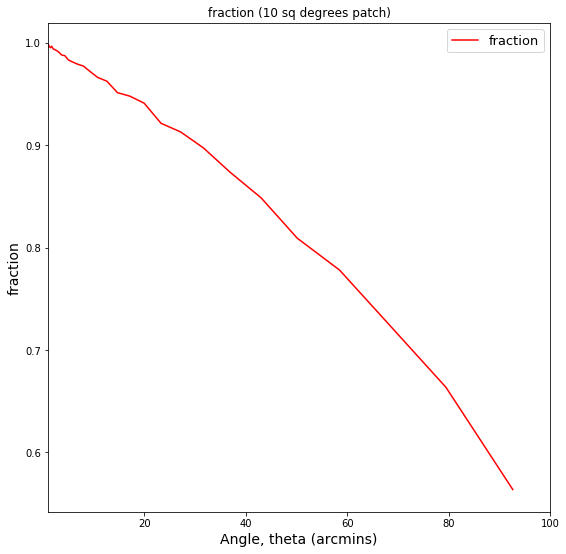

In [21]:
plt.figure(figsize=(9,9))
plt.plot(theta_scale_vec, frac_vec, c='r', label='fraction')
plt.xlim(1,100)
#plt.axhline(0, linestyle='dashed')
plt.xlabel('Angle, theta (arcmins)', fontsize=14)
plt.ylabel('fraction', fontsize=14)
plt.title('fraction (10 sq degrees patch)')
plt.legend(fontsize=13)

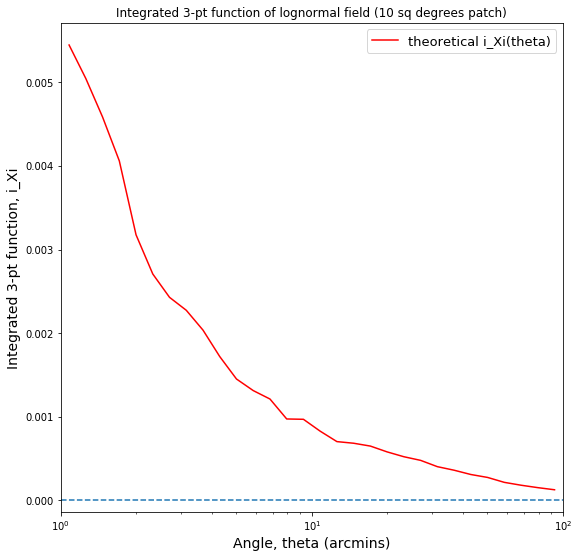

In [14]:
theta_scale_vec = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(0)) # in arcmins
i_Xi_vec = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(1))
plt.figure(figsize=(9,9))
plt.plot(theta_scale_vec, i_Xi_vec, c='r', label='theoretical i_Xi(theta)')
plt.xlim(1,100)
#plt.ylim(1e-6, 1e-1)
#plt.ylim(-0.005, 0.015)
plt.xscale('log')
#plt.yscale('log')
plt.axhline(0, linestyle='dashed')
plt.xlabel('Angle, theta (arcmins)', fontsize=14)
plt.ylabel('Integrated 3-pt function, i_Xi', fontsize=14)
plt.title('Integrated 3-pt function of lognormal field (10 sq degrees patch)')
plt.legend(fontsize=13)
#plt.savefig('i_Xi_lognormal_theoretical_patch_10_sq_degrees.pdf')

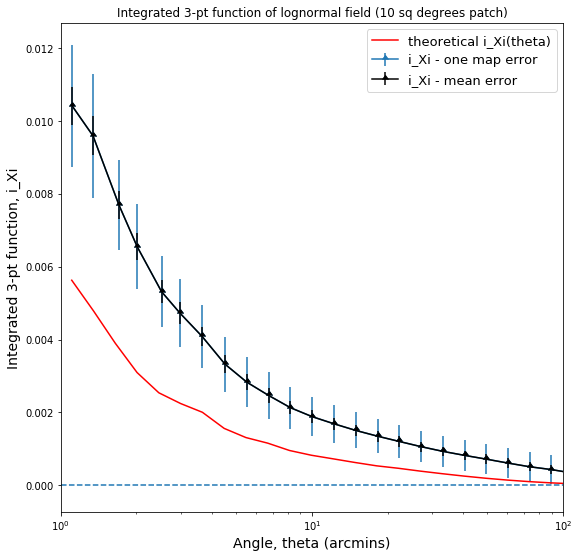

In [2]:
theta_scale_vec_i_Xi = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(0)) # in arcmins
i_Xi_vec = np.loadtxt('i_Xi_theoretical_lognormal_patch_10_sq_degrees.txt', usecols=(1))

theta_mean_all_maps_vec = np.loadtxt('i_Xi_simulations_lognormal_10_maps_500_patches_10_sq_degrees.txt', usecols=(0)) # in arcmins
i_Xi_mean_all_maps_vec = np.loadtxt('i_Xi_simulations_lognormal_10_maps_500_patches_10_sq_degrees.txt', usecols=(1))
i_Xi_std_dev_all_maps_vec = np.loadtxt('i_Xi_simulations_lognormal_10_maps_500_patches_10_sq_degrees.txt', usecols=(2))
i_Xi_std_dev_mean_all_maps_vec = np.loadtxt('i_Xi_simulations_lognormal_10_maps_500_patches_10_sq_degrees.txt', usecols=(3))


plt.figure(figsize=(9,9))
plt.plot(theta_scale_vec_i_Xi, i_Xi_vec, c='r', label='theoretical i_Xi(theta)')
plt.errorbar(theta_mean_all_maps_vec, i_Xi_mean_all_maps_vec, yerr=i_Xi_std_dev_all_maps_vec, marker=10, label='i_Xi - one map error')
plt.errorbar(theta_mean_all_maps_vec, i_Xi_mean_all_maps_vec, yerr=i_Xi_std_dev_mean_all_maps_vec, marker=10, color='k', label='i_Xi - mean error')
plt.xlim(1,100)
#plt.ylim(1e-6, 1e-1)
#plt.ylim(-0.005, 0.015)
plt.xscale('log')
#plt.yscale('log')
plt.axhline(0, linestyle='dashed')
plt.xlabel('Angle, theta (arcmins)', fontsize=14)
plt.ylabel('Integrated 3-pt function, i_Xi', fontsize=14)
plt.title('Integrated 3-pt function of lognormal field (10 sq degrees patch)')
plt.legend(fontsize=13)
#plt.savefig('i_Xi_lognormal_theoretical_patch_10_sq_degrees.pdf')

In [3]:
i_Xi_mean_all_maps_vec/i_Xi_vec

/home/anik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([  1.84916812,   2.00386428,   1.97528651,   2.1147901 ,
         2.09375131,   2.10590215,   2.0394066 ,   2.13001123,
         2.16243946,   2.1326988 ,   2.22987667,   2.28396019,
         2.32487522,   2.40573315,   2.52630139,   2.57870344,
         2.72546936,   2.92234951,   3.24861278,   3.70579403,
         4.26842591,   5.06640899,   6.51899885,   8.12112149,
        11.14624544,  20.00989436, 177.43416095,          nan,
                nan,          nan])

/home/anik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


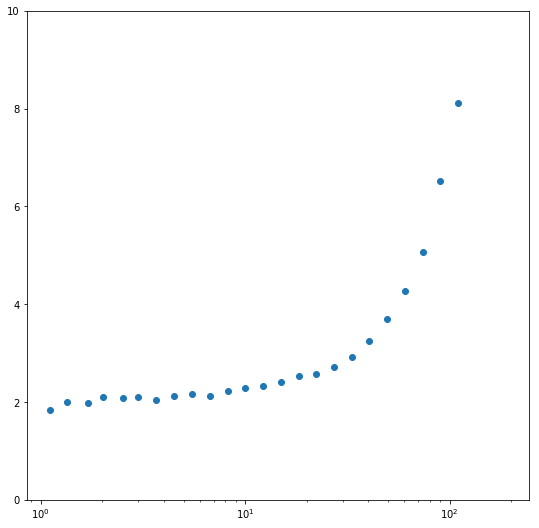

In [6]:
plt.figure(figsize=(9,9))
plt.scatter(theta_mean_all_maps_vec, i_Xi_mean_all_maps_vec/i_Xi_vec)
plt.ylim(0,10)
plt.xscale('log')

In [2]:
kk = treecorr.KKCorrelation(min_sep=1, max_sep=400, nbins=30, sep_units='arcmin')
theta_scale_log_vec = kk.logr # in log arcmins

In [3]:
theta_scale_log_vec

array([0.09985774, 0.29957323, 0.49928871, 0.6990042 , 0.89871968,
       1.09843517, 1.29815065, 1.49786614, 1.69758162, 1.89729711,
       2.09701259, 2.29672808, 2.49644356, 2.69615905, 2.89587453,
       3.09559002, 3.2953055 , 3.49502099, 3.69473647, 3.89445196,
       4.09416744, 4.29388293, 4.49359841, 4.6933139 , 4.89302938,
       5.09274487, 5.29246035, 5.49217583, 5.69189132, 5.8916068 ])

In [4]:
theta_scale_vec = np.exp(theta_scale_log_vec)

theta_scale_vec

array([  1.10501371,   1.34928285,   1.64754897,   2.0117484 ,
         2.45645605,   2.99946868,   3.66251713,   4.47213595,
         5.46072531,   6.66784758,   8.14181063,   9.94160102,
        12.13924462,  14.82268898,  18.09932294,  22.10027421,
        26.98565695,  32.95097945,  40.2349681 ,  49.12912104,
        59.98937364,  73.25034263,  89.4427191 , 109.21450621,
       133.35695165, 162.83621261, 198.83202046, 242.7848924 ,
       296.45377964, 361.98645886])

In [21]:
bin_width_log = theta_scale_log_vec[1]-theta_scale_log_vec[0]

theta_scale_log_bin_edges = np.zeros(theta_scale_log_vec.size + 1)

theta_scale_log_bin_edges[0] = theta_scale_log_bin_edges[0]-bin_width_log/2
for i in range(len(theta_scale_log_vec)):
    theta_scale_log_bin_edges[i+1] = theta_scale_log_vec[i]+bin_width_log/2

theta_scale_bin_edges = np.exp(theta_scale_log_bin_edges)

In [22]:
theta_scale_log_bin_edges

array([-0.09985774,  0.19971548,  0.39943097,  0.59914645,  0.79886194,
        0.99857742,  1.19829291,  1.39800839,  1.59772388,  1.79743936,
        1.99715485,  2.19687033,  2.39658582,  2.5963013 ,  2.79601679,
        2.99573227,  3.19544776,  3.39516324,  3.59487873,  3.79459421,
        3.9943097 ,  4.19402518,  4.39374067,  4.59345615,  4.79317164,
        4.99288712,  5.19260261,  5.39231809,  5.59203358,  5.79174906,
        5.99146455])

In [23]:
theta_scale_bin_edges = np.exp(theta_scale_log_bin_edges)

In [24]:
theta_scale_bin_edges

array([  0.90496615,   1.2210553 ,   1.49097605,   1.8205642 ,
         2.22300957,   2.71441762,   3.31445402,   4.04713164,
         4.94177154,   6.03417634,   7.368063  ,   8.99681237,
        10.98560543,  13.41403174,  16.37927455,  20.        ,
        24.421106  ,  29.81952092,  36.41128406,  44.46019138,
        54.28835233,  66.28908035,  80.94263289,  98.8354309 ,
       120.68352673, 147.36125995, 179.93624748, 219.71210866,
       268.28063477, 327.58549099, 400.        ])

In [25]:
for i in range(theta_scale_log_vec.size):
    print('###############################################################################')
    print('Iteration #',str(i+1))
    #start_iter = time.time()
    print('Theta (in arcmins): ', theta_scale_vec[i]) # nominal bin center
    theta_scale_interval = [theta_scale_bin_edges[i]*np.pi/180/60, theta_scale_bin_edges[i+1]*np.pi/180/60]  # from arcmins to radians
    #i_Xi_vec[i] = integrated_lognormal_3pt_corr_vegas(theta_scale_interval, t_patch_radius, log_shift, A_L)
    print(theta_scale_interval)
    #end_iter = time.time()
    #print('Time taken for execution of iteration (seconds): ', end_iter - start_iter)

###############################################################################
Iteration # 1
Theta (in arcmins):  1.1050137103527575
[0.00026324398144604035, 0.00035519058891844]
###############################################################################
Iteration # 2
Theta (in arcmins):  1.3492828476735632
[0.00035519058891844, 0.0004337073511329821]
###############################################################################
Iteration # 3
Theta (in arcmins):  1.6475489724420656
[0.0004337073511329821, 0.0005295806597791935]
###############################################################################
Iteration # 4
Theta (in arcmins):  2.01174840492126
[0.0005295806597791935, 0.0006466472714366638]
###############################################################################
Iteration # 5
Theta (in arcmins):  2.4564560522315806
[0.0006466472714366638, 0.0007895920780619699]
###############################################################################
Iteration # 6
Theta 